# *Import Libraries*

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score,auc,roc_curve, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# *Import Dataset*

In [2]:
!gdown --id 1x82hb4NkN5lBLAYvyBSBNUNJmJklN_1V

df = pd.read_csv("credit_scoring.csv")
df.head()

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1x82hb4NkN5lBLAYvyBSBNUNJmJklN_1V
To: /content/credit_scoring.csv
100% 46.7M/46.7M [00:00<00:00, 131MB/s]


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,NaN,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,NaN,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474.0,-1134.0,1.0,0.0,0.0,0.0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1


# *Check info and missing values*

In [3]:
df_info = {
    'columns': df.columns.to_list(),
    'missing values': df.isna().sum(),
    'shape': df.shape,
    'duplicated values': df.duplicated().sum()
}

for key,value in df_info.items():
  print(f'{key.capitalize()}')
  print(value)
  print('\n' + '*'*50 + '\n')

Columns
['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'TARGET']

**************************************************

Missing values
ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          1
NAME_HOUSING_TYPE           1
DAYS_BIRTH                  1
DAYS_EMPLOYED               1
FLAG_MOBIL                  1
FLAG_WORK_PHONE             1
FLAG_PHONE                  1
FLAG_EMAIL                  1
OCCUPATION_TYPE        103342
CNT_FAM_MEMBERS             1
TARGET                      0
dtype: int64

*********************

In [4]:
#drop row with > 60% missing values and ID columns
df.dropna(subset=["NAME_FAMILY_STATUS"], inplace=True)
df.drop(["ID"], axis= 1, inplace=True)

In [7]:
#drop duplicates and fill columns with NaN values
df = df.drop_duplicates()
df.loc[(df["NAME_INCOME_TYPE"] == "Pensioner"),"OCCUPATION_TYPE"] = "Pensioner"
df["OCCUPATION_TYPE"] = df["OCCUPATION_TYPE"].fillna("Unknown")

# *Exploration Data Analysis*

In [ ]:
_ = df['TARGET'].value_counts()
print(_)

TARGET
0    67886
1     7370
Name: count, dtype: int64


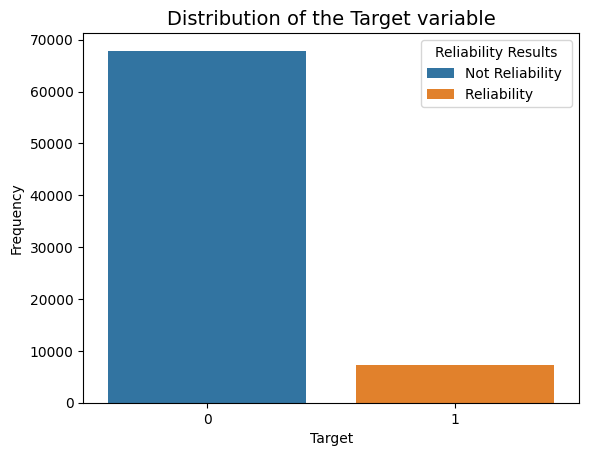

In [ ]:
sns.countplot(data=df, x="TARGET", hue ="TARGET")
plt.title("Distribution of the Target variable", fontsize=14)
plt.xlabel("Target")
plt.ylabel("Frequency")
plt.legend(labels=["Not Reliability ", "Reliability "], title="Reliability Results")
plt.show()

The dataset consists of 67,886 observations belonging to class 0 and 7,370 belonging to class 1.

The dataset is ***unbalanced.***

In [ ]:
cgt = df.groupby(["CODE_GENDER","TARGET"]).size().reset_index(name="count")
print(cgt)

  CODE_GENDER  TARGET  count
0           F       0  44469
1           F       1   4536
2           M       0  23417
3           M       1   2834


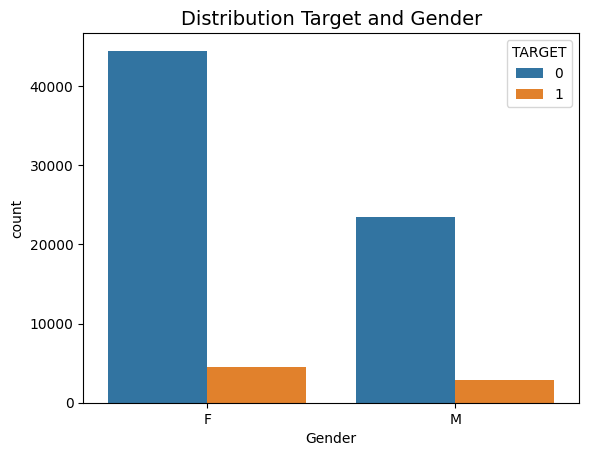

In [ ]:
sns.barplot(data = cgt, x = "CODE_GENDER", y= "count" ,hue = "TARGET")
plt.title("Distribution Target and Gender", fontsize=14)
plt.xlabel("Gender")
plt.show()

Women (F) outnumber men (M) in the category with low creditworthiness (0).

There are 44,469 women who consistently failed to pay their instalments, compared to 23,417 men in the same condition.

Even among people with high creditworthiness (1), there are more women (4,536) than men (2,834).

***However, the absolute difference is smaller compared to those with low creditworthiness.***

Overall, women tend to show a slightly better distribution in terms of creditworthiness than men, as the percentage of women with high reliability is higher than that of men.

In [ ]:
nit_pivot = df.groupby(['NAME_INCOME_TYPE', 'TARGET']).size().unstack(fill_value=0)
print(nit_pivot)

TARGET                    0     1
NAME_INCOME_TYPE                 
Commercial associate  15610  2457
Pensioner             12115     0
State servant          5016   873
Student                   6     1
Working               35139  4039


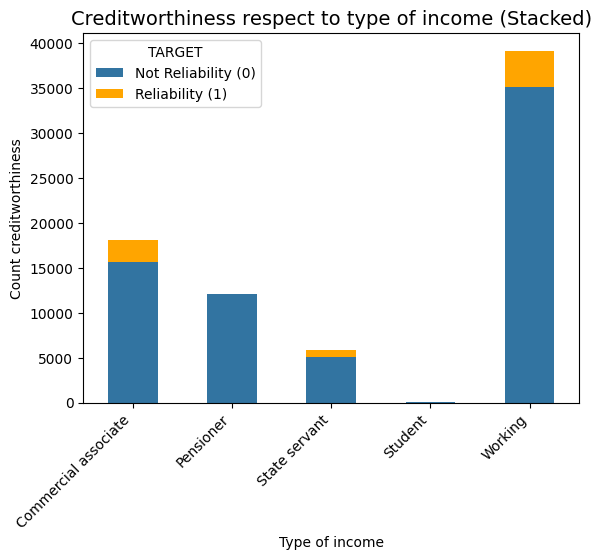

In [ ]:
_ = nit_pivot.plot(kind="bar", stacked=True, color=["#3274A1", "orange"])

plt.title("Creditworthiness respect to type of income (Stacked)", fontsize=14)
plt.xlabel("Type of income")
plt.ylabel("Count creditworthiness")
plt.xticks(rotation=45, ha="right")
plt.legend(title="TARGET", labels=["Not Reliability (0)", "Reliability (1)"])
plt.show()

**Commercial associate: ≈13.6% reliable**

15,610 customers with TARGET = 0 (low reliability).
2,457 customers with TARGET = 1 (high reliability).

**Pensioners: 0% reliable**

12,115 pensioners with TARGET = 0 (low reliability).
There are no pensioners with high reliability (TARGET = 1).

**State servant: ≈14.8% reliable**

5,016 state employees with TARGET = 0 (low reliability).
873 state employees with TARGET = 1 (high reliability).

**Students: ≈14.3% reliable**

Only 6 students with TARGET = 0 (low reliability).
Only 1 student with TARGET = 1 (high reliability).

**Working: ≈10.3% reliable**

35,139 workers with TARGET = 0 (low reliability).
4,039 workers with TARGET = 1 (high reliability).

In [ ]:
foc = df.groupby(["FLAG_OWN_CAR","TARGET"]).size().reset_index(name="count")
print(foc)

  FLAG_OWN_CAR  TARGET  count
0            N       0  43525
1            N       1   4152
2            Y       0  24361
3            Y       1   3218


In [ ]:
net_pivot = df.groupby(["NAME_EDUCATION_TYPE","TARGET"]).size().unstack(fill_value=0)
print(net_pivot)

TARGET                             0     1
NAME_EDUCATION_TYPE                       
Academic degree                   40     7
Higher education               16910  2277
Incomplete higher               2361   165
Lower secondary                  744    38
Secondary / secondary special  47831  4883


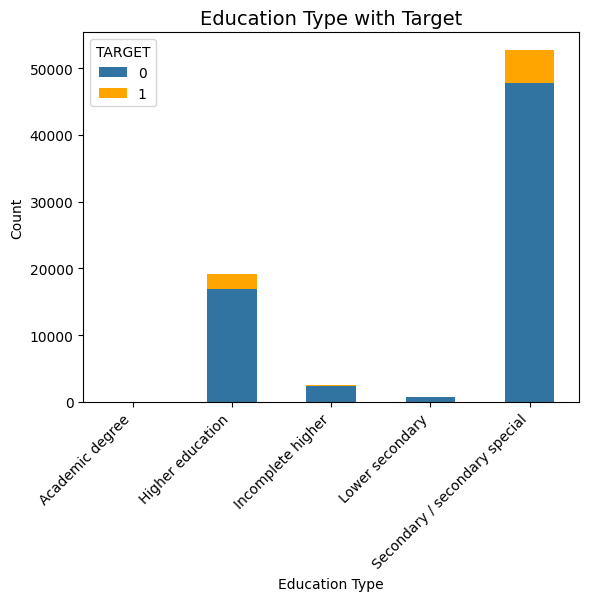

In [ ]:
_ = net_pivot.plot(kind="bar", stacked=True, color=["#3274A1", "orange"])
plt.title("Education Type with Target", fontsize=14)
plt.xlabel("Education Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()

People with a **higher education and Seconday/s. special tend to have a higher creditworthiness**.

People with a higher level and Secondary level of education **might have more stable and continuous careers, reducing the risk of default.**

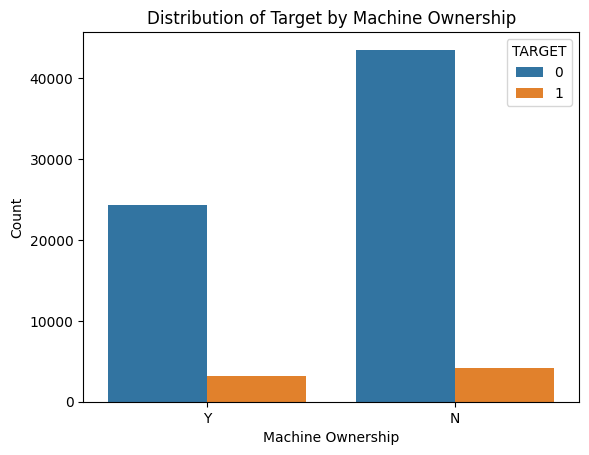

In [ ]:
sns.countplot(data=df, x="FLAG_OWN_CAR", hue="TARGET")
plt.title("Distribution of Target by Machine Ownership")
plt.xlabel("Machine Ownership")
plt.ylabel("Count")
plt.show()

From the graph, we can see that there is a large number of people without a car who have low creditworthiness (43,525 people ).

The figure of people without a car with high creditworthiness is significantly lower, 4,152 people.

**Similar trend for people with a car:**

People with a car tend to have lower creditworthiness (24,361 people) than those with high creditworthiness (3,218 people).

**There are many more people without a car who have low creditworthiness than those who own a car.**

# *Data Preprocessing*

In [ ]:
binary_columns = ["CODE_GENDER","FLAG_OWN_CAR","FLAG_OWN_REALTY"]

le = LabelEncoder()
for col in binary_columns:
  df[col]= le.fit_transform(df[col])

In [ ]:
categorical_columns = ["NAME_INCOME_TYPE",
                       "NAME_EDUCATION_TYPE",
                       "NAME_FAMILY_STATUS",
                       "NAME_HOUSING_TYPE",
                       "OCCUPATION_TYPE"]

df = pd.get_dummies(df,columns = categorical_columns, drop_first=True).astype(int) #to exclude collinearity drop_first=True

In [ ]:
df.describe()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,...,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Pensioner,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Unknown,OCCUPATION_TYPE_Waiters/barmen staff
count,75256.000000,75256.000000,75256.000000,75256.000000,7.525600e+04,75256.000000,75256.000000,75256.0,75256.000000,75256.000000,...,75256.000000,75256.000000,75256.000000,75256.000000,75256.000000,75256.000000,75256.000000,75256.000000,75256.000000,75256.000000
mean,0.348823,0.366469,0.682683,0.409070,1.848544e+05,-16076.620695,56591.817689,1.0,0.206974,0.282569,...,0.079954,0.028928,0.160984,0.008584,0.002644,0.098304,0.004491,0.019812,0.133013,0.004106
std,0.476601,0.481843,0.465435,0.719442,1.069342e+05,4185.574252,135218.584928,0.0,0.405139,0.450251,...,0.271223,0.167605,0.367518,0.092252,0.051355,0.297728,0.066867,0.139356,0.339591,0.063947
min,0.000000,0.000000,0.000000,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.125000e+05,-19482.000000,-3124.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,1.575000e+05,-15969.500000,-1493.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,2.250000e+05,-12600.750000,-398.000000,1.0,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#Set Variables
X = df.drop(["TARGET"], axis = 1).values
y = df["TARGET"].values

X.shape, y.shape

((75256, 48), (75256,))

In [ ]:
#Split train e test set
RANDOM_SEED= 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_SEED, stratify= y)

In [ ]:
#StandarScaler
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

X_train.shape , X_test.shape

((60204, 48), (15052, 48))

In [ ]:
X_train.mean() , X_train.std()

(-1.8795699856024746e-17, 0.9895285072532629)

# *Logistic regression - Class Weight: "Balanced"*

In [ ]:
#fit LogisticRegression
lr = LogisticRegression(class_weight="balanced", random_state=RANDOM_SEED)
lr.fit(X_train,y_train)

y_pred_train = lr.predict(X_train)
y_proba_train = lr.predict_proba(X_train)

y_pred_test = lr.predict(X_test)
y_proba_test = lr.predict_proba(X_test)

#Confusion matrix and Classification reports
cm = confusion_matrix(y_test,y_pred_test)
print(cm)
print(f"*" * 60)
print(f"Train Report")
print(classification_report(y_train,y_pred_train))
print(f"*" * 60)
print(f"Test Report")
print(classification_report(y_test,y_pred_test))
print(f"*" * 60)
print("Train ROC-AUC:", (roc_auc_score(y_train, y_proba_train[:, 1])))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba_test[:, 1]))


[[10757  2821]
 [  196  1278]]
************************************************************
Train Report
              precision    recall  f1-score   support

           0       0.98      0.79      0.88     54308
           1       0.32      0.89      0.47      5896

    accuracy                           0.80     60204
   macro avg       0.65      0.84      0.67     60204
weighted avg       0.92      0.80      0.84     60204

************************************************************
Test Report
              precision    recall  f1-score   support

           0       0.98      0.79      0.88     13578
           1       0.31      0.87      0.46      1474

    accuracy                           0.80     15052
   macro avg       0.65      0.83      0.67     15052
weighted avg       0.92      0.80      0.84     15052

************************************************************
Train ROC-AUC: 0.901848726918049
Test ROC-AUC: 0.8976649412720273


# *Smote Model*

In [ ]:
#fit smote
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)

model= LogisticRegression(random_state=RANDOM_SEED, max_iter=500)
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)
y_pred_train_resampled = model.predict(X_train_resampled)

y_proba_train_smote = model.predict_proba(X_train)
y_proba_test_smote = model.predict_proba(X_test)

cm_smote = confusion_matrix(y_test,y_pred)
print(cm_smote)
print(f"*" * 60)
print(f"Train Report")
print(classification_report(y_train_resampled,y_pred_train_resampled))
print(f"*" * 60)
print(f"Test Report")
print(classification_report(y_test,y_pred))
print(f"*" * 60)
print("Train ROC-AUC:", roc_auc_score(y_train, y_proba_train_smote[:, 1]))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba_test_smote[:, 1]))


[[10925  2653]
 [  227  1247]]
************************************************************
Train Report
              precision    recall  f1-score   support

           0       0.90      0.80      0.85     54308
           1       0.82      0.91      0.87     54308

    accuracy                           0.86    108616
   macro avg       0.86      0.86      0.86    108616
weighted avg       0.86      0.86      0.86    108616

************************************************************
Test Report
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     13578
           1       0.32      0.85      0.46      1474

    accuracy                           0.81     15052
   macro avg       0.65      0.83      0.67     15052
weighted avg       0.92      0.81      0.84     15052

************************************************************
Train ROC-AUC: 0.9022883115965833
Test ROC-AUC: 0.897904423969415


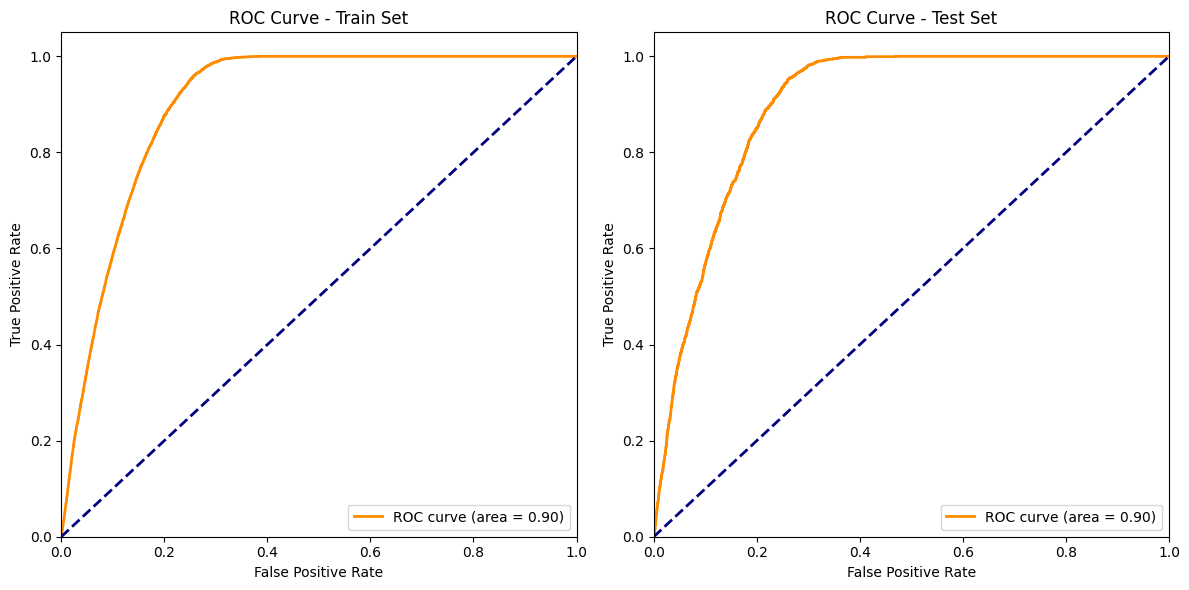

In [ ]:
# ROC Curve for Train Set
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_proba_train[:, 1])
roc_auc_train = auc(fpr_train, tpr_train)

# ROC Curve for Test Set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_proba_test[:, 1])
roc_auc_test = auc(fpr_test, tpr_test)

# Plotting
plt.figure(figsize=(12, 6))

# Plot for Train Set
plt.subplot(1, 2, 1)
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Train Set')
plt.legend(loc="lower right")

# Plot for Test Set
plt.subplot(1, 2, 2)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# *Random Forest*

In [ ]:
#random forest
rf = RandomForestClassifier(n_estimators=100,
                            max_features=0.8,
                            max_depth=5,
                            criterion="gini",
                            min_samples_split=5,
                            random_state=RANDOM_SEED)

In [ ]:
rf.fit(X_train_resampled, y_train_resampled)

y_pred_train_rf = rf.predict(X_train)
y_proba_train_rf = rf.predict_proba(X_train)[:, 1]

y_pred_test_rf = rf.predict(X_test)
y_proba_test_rf = rf.predict_proba(X_test)[:, 1]

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_test_rf)
print(cm_rf)
print(f"*" * 60)
report_rf_train = classification_report(y_train, y_pred_train_rf)
print(report_rf_train)
print(f"*" * 60)
report_rf_test = classification_report(y_test, y_pred_test_rf)
print(report_rf_test)
print(f"*" * 60)
print("Train ROC-AUC:", roc_auc_score(y_train, y_proba_train_rf))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba_test_rf))

[[12402  1176]
 [    0  1474]]
************************************************************
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     54308
           1       0.56      1.00      0.72      5896

    accuracy                           0.92     60204
   macro avg       0.78      0.96      0.84     60204
weighted avg       0.96      0.92      0.93     60204

************************************************************
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     13578
           1       0.56      1.00      0.71      1474

    accuracy                           0.92     15052
   macro avg       0.78      0.96      0.83     15052
weighted avg       0.96      0.92      0.93     15052

************************************************************
Train ROC-AUC: 0.9584726317024491
Test ROC-AUC: 0.9562454669168119


In the confusion matrix:
* True Negatives are 12401
* False Positives are 1177
* False Negatives are 0
* True Positives are 1474
---
**Precision:** 0.56 - **Recall:** 1.00 - **F1-score:** 0.71 - **Accuracy:** 0.92

The random forest model was adapted to the train set sampled by smote because unbalanced dataset, tending towards class 0.

ROC-AUC value is 0.95 on test set, the model performs well to distinguish two classes.


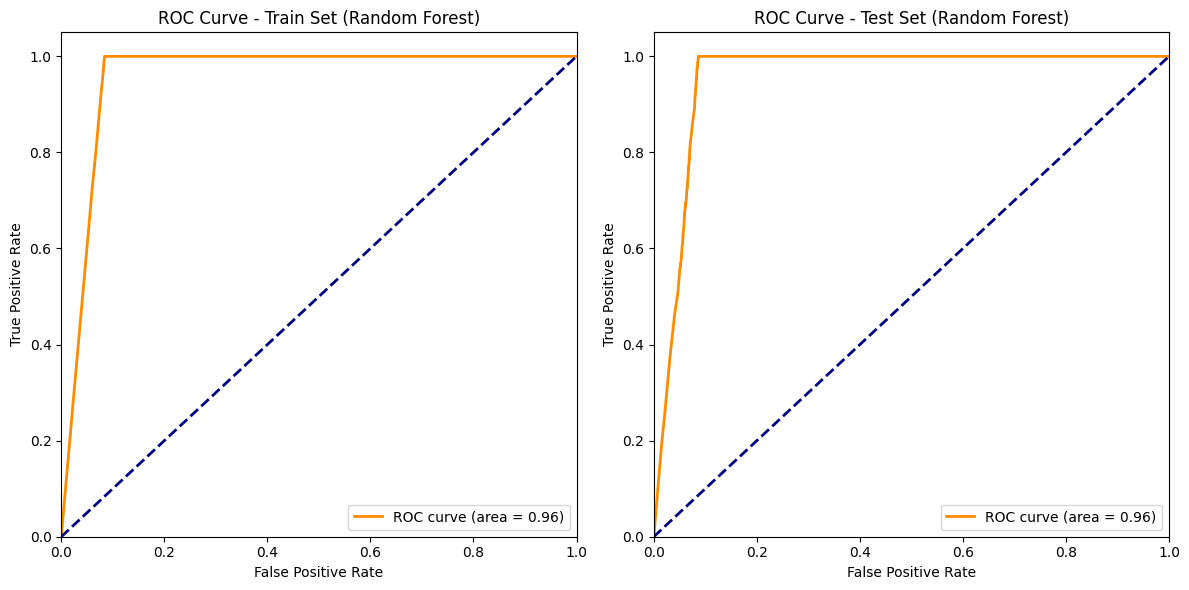

In [ ]:
# ROC Curve for Train Set
fpr_train_rf, tpr_train_rf, thresholds_train_rf = roc_curve(y_train, y_proba_train_rf)
roc_auc_train_rf = auc(fpr_train_rf, tpr_train_rf)

# ROC Curve for Test Set
fpr_test_rf, tpr_test_rf, thresholds_test_rf = roc_curve(y_test, y_proba_test_rf)
roc_auc_test_rf = auc(fpr_test_rf, tpr_test_rf)

# Plotting
plt.figure(figsize=(12, 6))

# Plot for Train Set
plt.subplot(1, 2, 1)
plt.plot(fpr_train_rf, tpr_train_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_train_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Train Set (Random Forest)')
plt.legend(loc="lower right")

# Plot for Test Set
plt.subplot(1, 2, 2)
plt.plot(fpr_test_rf, tpr_test_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set (Random Forest)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [ ]:
#Bonus: features importance Random Forest model
importances = rf.feature_importances_
features = df.drop(columns=["TARGET"]).columns
sorted_importances = sorted(zip(features,importances), key = lambda x: x[1], reverse=True)

print("Feature Importance:")
for feature, importance in sorted_importances:
  print(f"{feature}: {importance:.2f}")

Feature Importance:
AMT_INCOME_TOTAL: 0.41
DAYS_BIRTH: 0.31
DAYS_EMPLOYED: 0.26
OCCUPATION_TYPE_Pensioner: 0.01
CNT_CHILDREN: 0.00
NAME_INCOME_TYPE_Pensioner: 0.00
CNT_FAM_MEMBERS: 0.00
FLAG_OWN_CAR: 0.00
NAME_INCOME_TYPE_Working: 0.00
CODE_GENDER: 0.00
FLAG_WORK_PHONE: 0.00
NAME_FAMILY_STATUS_Married: 0.00
NAME_EDUCATION_TYPE_Secondary / secondary special: 0.00
OCCUPATION_TYPE_High skill tech staff: 0.00
NAME_FAMILY_STATUS_Separated: 0.00
NAME_INCOME_TYPE_State servant: 0.00
FLAG_PHONE: 0.00
OCCUPATION_TYPE_Core staff: 0.00
FLAG_OWN_REALTY: 0.00
NAME_FAMILY_STATUS_Widow: 0.00
NAME_EDUCATION_TYPE_Higher education: 0.00
OCCUPATION_TYPE_Sales staff: 0.00
OCCUPATION_TYPE_Managers: 0.00
NAME_HOUSING_TYPE_House / apartment: 0.00
OCCUPATION_TYPE_Laborers: 0.00
OCCUPATION_TYPE_Unknown: 0.00
NAME_HOUSING_TYPE_Office apartment: 0.00
NAME_EDUCATION_TYPE_Incomplete higher: 0.00
OCCUPATION_TYPE_Drivers: 0.00
OCCUPATION_TYPE_Medicine staff: 0.00
NAME_FAMILY_STATUS_Single / not married: 0.00
FLAG_EM

**AMT_INCOME_TOTAL (41%):**

This variable, which represents the customer's total income, is the most important in determining creditworthiness.
It implies that there is a strong correlation between income and the probability of paying regular instalments.

**DAYS_BIRTH (32%):**

The number of days since birth (age of the customer) is almost as important.
It could mean that younger or older customers show different patterns of financial reliability.

**DAYS_EMPLOYED (25%):**

Days worked (or time since being unemployed) is also a crucial variable.
It seems that job stability is a relevant factor in determining whether a customer is reliable or not.

**NAME_INCOME_TYPE_Pensioner (1%):**

This value is very low compared to the others, which indicates that being a pensioner does not have a large isolated impact on predictions.
This does not mean that pensioners are not reliable, but rather that other variables (such as income or age) play a much more important role.

# *Final Conclusions:*

The variables to be taken into account for creditworthiness are mainly four:
* Annual income
* Age
* Days of employment
* Category (Pensioner, Working ect.)

Also remember, in this case, that people with a higher education and Secondary/secondary special tend to have a higher creditworthiness.

**Targeting these segments could make it clear whether or not to accept the application for a credit card.**

If a customer’s credit card application is denied, a clear explanation must be provided. To have their request approved, the customer must fall into a category with a high likelihood of reliability.

**Negative example:** A pensioner may be denied, as the data shows that 100% of pensioners are considered unreliable.

**Positive example:** A customer with a strong/good annual income, a young age, long-term employment, and a high or secondary-special education level is more likely to have their application approved.